# Testing EfficientNet 

In [1]:
import tensorflow as tf
import data.imageReading as ir
from fairness import fairnessMetrics as fm
from model import model as m
from model import utils as utils
from model import biasMitigation as mit
from model import evaluation as ev
from tuning import callbacks as cb
import datetime
import os
import numpy as np

In [2]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

image_size = (300,300)
batch_size = 32
epochs = 20
#(ds_train, train_batches, ds_val, val_batches, ds_test, test_batches, count_classes) = ir.readData("/mimer/NOBACKUP/groups/snic2022-22-1091/museumFaces", image_size, batch_size, preprocess_input)
#(ffds_train, fftrain_batches, ffds_val, ffval_batches, ffds_test, fftest_batches, ffcount_classes) = ir.readData("/mimer/NOBACKUP/groups/snic2022-22-1091/FairFace", image_size, batch_size, preprocess_input)
(ds_train, train_batches, ds_val, val_batches, ds_test, test_batches, count_classes) = ir.readData("/mimer/NOBACKUP/groups/snic2022-22-1091/museumFaces_split", image_size, batch_size, preprocess_input, None, False, False)
(ffds_train, fftrain_batches, ffds_val, ffval_batches, ffds_test, fftest_batches, ffcount_classes) = ir.readData("/mimer/NOBACKUP/groups/snic2022-22-1091/FairFace_split", image_size, batch_size, preprocess_input, None, False, False)


options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
ds_train = ds_train.with_options(options)
ds_val = ds_val.with_options(options)
ds_test = ds_test.with_options(options)

Found 3916 images belonging to 2 classes.
Found 489 images belonging to 2 classes.
Found 492 images belonging to 2 classes.
Count classes: (2052, 1864, 256, 233, 258, 234)
Found 78158 images belonging to 2 classes.
Found 9769 images belonging to 2 classes.
Found 9771 images belonging to 2 classes.
Count classes: (36736, 41422, 4592, 5177, 4592, 5179)


## Find learning rate

In [3]:
class_weight = mit.findClassWeights(train_batches)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = m.build_model(False, (300,300), "Efficient")
    metric_list = m.metrics_list()

model.compile(optimizer=tf.keras.optimizers.Adam(), 
                           loss="binary_crossentropy", 
                           metrics="accuracy")


Weight for class 0: 0.95
Weight for class 1: 1.05
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:local

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
10/10 - 73s - loss: 0.9316 - accuracy: 0.5250 - 73s/epoch - 7s/step
Epoch 2/200
10/10 - 6s - loss: 0.8354 - accuracy: 0.5531 - 6s/epoch - 623ms/step
Epoch 3/200
10/10 - 6s - loss: 0.9152 - accuracy: 0.5156 - 6s/epoch - 626ms/step
Epoch 4/200
10/10 - 6s - loss: 0.9118 - accuracy: 0.5000 - 6s/epoch - 622ms/step
Epoch 5/200
10/10 - 6s - loss: 0.8824 - accuracy: 0.5188 - 6s/epoch - 624ms/step
Epoch 6/200
10/10 - 6s - loss: 0.9587 - accuracy: 0.5031 - 6s/epoch - 625ms/step
Epoch 7/200
10/10 - 6s - loss: 0.8488 - accuracy: 0.5156 - 6s/epoch - 622ms/step
Epoch 8/200
10/10 - 6s - loss: 0.8871 - accuracy: 0.5156 - 6s/epoch - 626ms/step
Epoch 9/200
10/10 - 6s - loss: 0.8823 - accuracy: 0.5281 - 6s/epoch - 629ms/step
Epoch 10/200
10/10 - 6s - loss: 0.9216 - accuracy: 0.5031 - 6s/epoch - 635ms/step
Epoch 11/200
10/

Epoch 99/200
10/10 - 6s - loss: 1.6804 - accuracy: 0.5033 - 6s/epoch - 608ms/step
Epoch 100/200
10/10 - 6s - loss: 1.3627 - accuracy: 0.4500 - 6s/epoch - 601ms/step


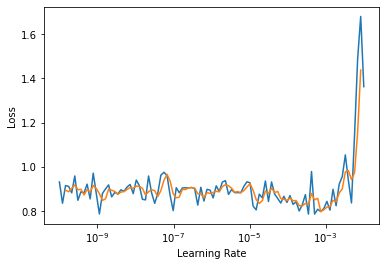

In [4]:
epochs = 200
train_input = []
train_output = []
nr_batches = 10

model.fit(ds_train, steps_per_epoch=nr_batches, callbacks=[cb.LerningRateCallback(100, nr_batches)], epochs=epochs, verbose=2)

## 5-Fold Cross Validation EfficientNet without Transfer Learning (unweighted)

In [3]:
preprocess = tf.keras.applications.efficientnet.preprocess_input
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    history = ev.kfoldCrossValidation("/mimer/NOBACKUP/groups/snic2022-22-1091/museumFaces", m.build_model(False, (300,300), "Efficient"), preprocess, 5e-5, (300,300), 5)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/apps/Arch/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


sc
Epoch 1/20
123/123 [==============================] - 151s 763ms/step - loss: 0.7374 - accuracy: 0.6118 - true_positives: 1170.0000 - true_negatives: 1219.0000 - false_positives: 789.0000 - false_negatives: 727.0000 - true_positive_rate: 0.6168 - true_negative_rate: 0.6071 - false_positive_rate: 0.3929 - false_negative_rate: 0.3832 - positive_predicted_value: 0.5972 - false_discovery_rate: 0.4028 - negative_predicted_value: 0.6264 - false_omission_rate: 0.3736 - binary_demographic_parity_diff: 13.0000 - demographic_parity: 1959.0000 - binary_equalized_odds_diff: -0.0097 - binary_proportional_parity_diff: 0.0033 - proportional_parity: 0.5017 - binary_predictive_rate_parity_diff: -0.0292 - predictive_rate_parity: 0.5972 - binary_accuracy_parity_diff: 0.2236 - accuracy_parity: 0.6118 - false_negative_rate_parity_diff: 0.0097 - false_positive_rate_parity_diff: -0.0097 - binary_negative_predictive_rate_parity_diff: 0.0292 - negative_predictive_rate_parity: 0.5972 - binary_specificity_par

sc
Epoch 5/20
123/123 [==============================] - 78s 636ms/step - loss: 0.3830 - accuracy: 0.8225 - true_positives: 1509.0000 - true_negatives: 1703.0000 - false_positives: 352.0000 - false_negatives: 341.0000 - true_positive_rate: 0.8157 - true_negative_rate: 0.8287 - false_positive_rate: 0.1713 - false_negative_rate: 0.1843 - positive_predicted_value: 0.8109 - false_discovery_rate: 0.1891 - negative_predicted_value: 0.8332 - false_omission_rate: 0.1668 - binary_demographic_parity_diff: -183.0000 - demographic_parity: 1861.0000 - binary_equalized_odds_diff: 0.0130 - binary_proportional_parity_diff: -0.0469 - proportional_parity: 0.4766 - binary_predictive_rate_parity_diff: -0.0223 - predictive_rate_parity: 0.8109 - binary_accuracy_parity_diff: 0.6451 - accuracy_parity: 0.8225 - false_negative_rate_parity_diff: -0.0130 - false_positive_rate_parity_diff: 0.0130 - binary_negative_predictive_rate_parity_diff: 0.0223 - negative_predictive_rate_parity: 0.8109 - binary_specificity_pa

sc
Epoch 9/20
123/123 [==============================] - 81s 658ms/step - loss: 0.2467 - accuracy: 0.8986 - true_positives: 1674.0000 - true_negatives: 1835.0000 - false_positives: 207.0000 - false_negatives: 189.0000 - true_positive_rate: 0.8986 - true_negative_rate: 0.8986 - false_positive_rate: 0.1014 - false_negative_rate: 0.1014 - positive_predicted_value: 0.8900 - false_discovery_rate: 0.1100 - negative_predicted_value: 0.9066 - false_omission_rate: 0.0934 - binary_demographic_parity_diff: -143.0000 - demographic_parity: 1881.0000 - binary_equalized_odds_diff: 7.8022e-05 - binary_proportional_parity_diff: -0.0366 - proportional_parity: 0.4817 - binary_predictive_rate_parity_diff: -0.0167 - predictive_rate_parity: 0.8900 - binary_accuracy_parity_diff: 0.7972 - accuracy_parity: 0.8986 - false_negative_rate_parity_diff: -7.8067e-05 - false_positive_rate_parity_diff: 7.8067e-05 - binary_negative_predictive_rate_parity_diff: 0.0167 - negative_predictive_rate_parity: 0.8900 - binary_sp

sc
Epoch 13/20
123/123 [==============================] - 80s 651ms/step - loss: 0.2024 - accuracy: 0.9183 - true_positives: 1720.0000 - true_negatives: 1866.0000 - false_positives: 160.0000 - false_negatives: 159.0000 - true_positive_rate: 0.9154 - true_negative_rate: 0.9210 - false_positive_rate: 0.0790 - false_negative_rate: 0.0846 - positive_predicted_value: 0.9149 - false_discovery_rate: 0.0851 - negative_predicted_value: 0.9215 - false_omission_rate: 0.0785 - binary_demographic_parity_diff: -145.0000 - demographic_parity: 1880.0000 - binary_equalized_odds_diff: 0.0056 - binary_proportional_parity_diff: -0.0371 - proportional_parity: 0.4814 - binary_predictive_rate_parity_diff: -0.0066 - predictive_rate_parity: 0.9149 - binary_accuracy_parity_diff: 0.8366 - accuracy_parity: 0.9183 - false_negative_rate_parity_diff: -0.0056 - false_positive_rate_parity_diff: 0.0056 - binary_negative_predictive_rate_parity_diff: 0.0066 - negative_predictive_rate_parity: 0.9149 - binary_specificity_p

sc
Epoch 17/20
123/123 [==============================] - 80s 647ms/step - loss: 0.1279 - accuracy: 0.9490 - true_positives: 1797.0000 - true_negatives: 1909.0000 - false_positives: 107.0000 - false_negatives: 92.0000 - true_positive_rate: 0.9513 - true_negative_rate: 0.9469 - false_positive_rate: 0.0531 - false_negative_rate: 0.0487 - positive_predicted_value: 0.9438 - false_discovery_rate: 0.0562 - negative_predicted_value: 0.9540 - false_omission_rate: 0.0460 - binary_demographic_parity_diff: -97.0000 - demographic_parity: 1904.0000 - binary_equalized_odds_diff: -0.0044 - binary_proportional_parity_diff: -0.0248 - proportional_parity: 0.4876 - binary_predictive_rate_parity_diff: -0.0102 - predictive_rate_parity: 0.9438 - binary_accuracy_parity_diff: 0.8981 - accuracy_parity: 0.9490 - false_negative_rate_parity_diff: 0.0044 - false_positive_rate_parity_diff: -0.0044 - binary_negative_predictive_rate_parity_diff: 0.0102 - negative_predictive_rate_parity: 0.9438 - binary_specificity_pa

sc
Epoch 1/20
116/123 [===========================>..] - ETA: 4s - loss: 0.1234 - accuracy: 0.9527 - true_positives_21: 1725.0000 - true_negatives_14: 1782.0000 - false_positives_17: 81.0000 - false_negatives_18: 93.0000 - true_positive_rate: 0.9488 - true_negative_rate: 0.9565 - false_positive_rate: 0.0435 - false_negative_rate: 0.0512 - positive_predicted_value: 0.9551 - false_discovery_rate: 0.0449 - negative_predicted_value: 0.9504 - false_omission_rate: 0.0496 - binary_demographic_parity_diff: -69.0000 - demographic_parity: 1806.0000 - binary_equalized_odds_diff: 0.0077 - binary_proportional_parity_diff: -0.0187 - proportional_parity: 0.4906 - binary_predictive_rate_parity_diff: 0.0047 - predictive_rate_parity: 0.9551 - binary_accuracy_parity_diff: 0.9055 - accuracy_parity: 0.9527 - false_negative_rate_parity_diff: -0.0077 - false_positive_rate_parity_diff: 0.0077 - binary_negative_predictive_rate_parity_diff: -0.0047 - negative_predictive_rate_parity: 0.9551 - binary_specificity_

KeyboardInterrupt: 

## Test EfficientNet without Transfer Learning (unweighted) 

In [4]:
epochs = 20
class_weight = mit.findClassWeights(train_batches)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = m.build_model(False, (300,300), "Efficient")
    metric_list = m.metrics_list()

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), 
                           loss="binary_crossentropy", 
                           metrics=metric_list)


utils.train_model(model, epochs, ds_train, train_batches, ds_val, val_batches, None, False)

print("Make folder...")
dir_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "_EfficientNet_unweighted"
os.mkdir(dir_name)

utils.saveModel(model, dir_name + "/EfficientNet_unweighted.h5")

Weight for class 0: 0.95
Weight for class 1: 1.05
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
sc
Epoch 1/20
123/123 [==============================] - 139s 724ms/step - loss: 0.7123 - accuracy: 0.6361 - true_positives_42: 1195.0000 - true_negatives_28: 1296.0000 - false_positives_34: 756.0000 - false_negatives_36: 669.0000 - true_positive_rate: 0.6411 - true_negative_rate: 0.6316 - false_positive_rate: 0.3684 - false_negative_rate: 0.3589 - positive_predicted_value: 0.6125 - false_discovery_rate: 0.3875 - negative_predicted_value: 0.6595 - false_omission_rate: 0.3405 - binary_demographic_parity_diff: -14.0000 - demographic_parity: 1951.0000 - binary_equalized_odds_diff: -0.0095 - binary_proportional_parity_diff: -0.0036 - proportional_parity: 0.4982 - binary_predictive_rate_parity_diff: -0.0470 - predictive_rate_parity: 0.6125 - binary_accuracy_parity_diff: 0.2722 - accuracy_parity: 0.6361 - false_negative_rate_parity_diff: 0.00

sc
Epoch 5/20
123/123 [==============================] - 77s 627ms/step - loss: 0.2572 - accuracy: 0.8935 - true_positives_42: 1662.0000 - true_negatives_28: 1837.0000 - false_positives_34: 215.0000 - false_negatives_36: 202.0000 - true_positive_rate: 0.8916 - true_negative_rate: 0.8952 - false_positive_rate: 0.1048 - false_negative_rate: 0.1084 - positive_predicted_value: 0.8855 - false_discovery_rate: 0.1145 - negative_predicted_value: 0.9009 - false_omission_rate: 0.0991 - binary_demographic_parity_diff: -162.0000 - demographic_parity: 1877.0000 - binary_equalized_odds_diff: 0.0036 - binary_proportional_parity_diff: -0.0414 - proportional_parity: 0.4793 - binary_predictive_rate_parity_diff: -0.0155 - predictive_rate_parity: 0.8855 - binary_accuracy_parity_diff: 0.7870 - accuracy_parity: 0.8935 - false_negative_rate_parity_diff: -0.0036 - false_positive_rate_parity_diff: 0.0036 - binary_negative_predictive_rate_parity_diff: 0.0155 - negative_predictive_rate_parity: 0.8855 - binary_sp

Make folder...


Testing Model
-------------
16/16 - 4s - 4s/epoch - 265ms/step
Plot Histogram...


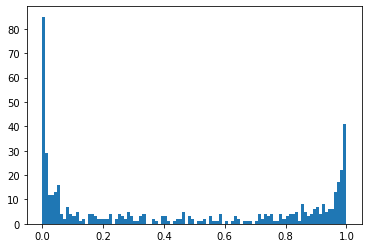

Plot ROC...


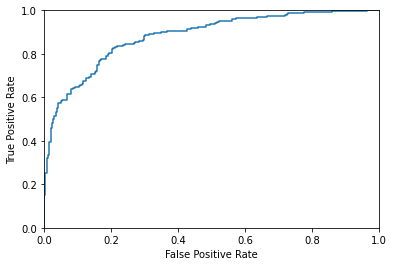

Plot Confusion matrix...


<Figure size 432x288 with 0 Axes>

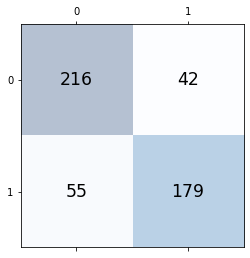

Plot Results...


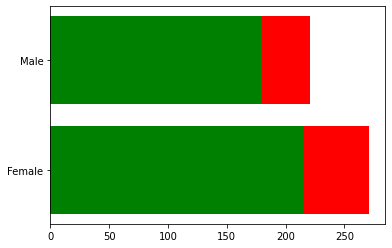


    Test results (Without threshold change):
    -------------
    
    Accuracy: 0.803
    
    True positives: 179.000
    False positives: 42.000
    
    True negatives: 216.000
    False negatives: 55.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.765
    True negative rate tn/(tn+fp): 0.837
    
    False negative rate fn/(tp+fn): 0.235
    False positive rate fp/(tn+fp): 0.163
    
    Positive predicted value tp/(tp+fp): 0.810
    False discovery rate fp/(tp+fp): 0.190
    
    Negative predicted value tn/(tn+fn): 0.797
    False omission rate fn/(tn+fn): 0.203
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -50.000
    Demographic parity tp+fp: 221.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.072
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.102
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.449
    
    Binary predictive rate parity diff 

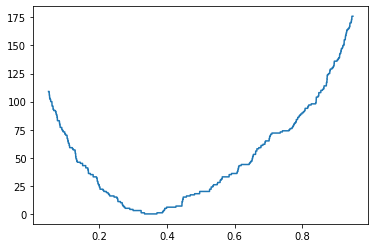

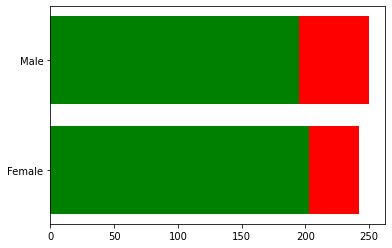


    Test results (Equal True):
    -------------
    
    Accuracy: 0.809
    
    True positives: 195.000
    False positives: 55.000
    
    True negatives: 203.000
    False negatives: 39.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.833
    True negative rate tn/(tn+fp): 0.787
    
    False negative rate fn/(tp+fn): 0.167
    False positive rate fp/(tn+fp): 0.213
    
    Positive predicted value tp/(tp+fp): 0.780
    False discovery rate fp/(tp+fp): 0.220
    
    Negative predicted value tn/(tn+fn): 0.839
    False omission rate fn/(tn+fn): 0.161
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 8.000
    Demographic parity tp+fp: 250.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): 0.047
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.016
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.508
    
    Binary predictive rate parity diff (tp/(tp+fp))-(tn/(

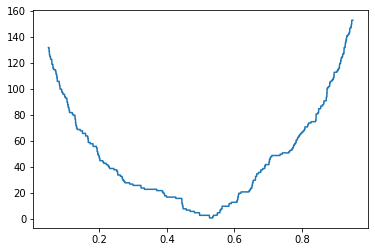

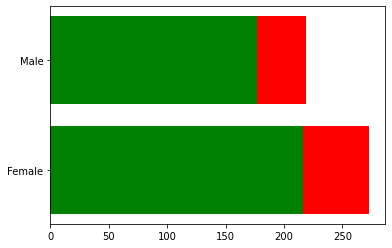


    Test results (Equal False):
    -------------
    
    Accuracy: 0.799
    
    True positives: 177.000
    False positives: 42.000
    
    True negatives: 216.000
    False negatives: 57.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.756
    True negative rate tn/(tn+fp): 0.837
    
    False negative rate fn/(tp+fn): 0.244
    False positive rate fp/(tn+fp): 0.163
    
    Positive predicted value tp/(tp+fp): 0.808
    False discovery rate fp/(tp+fp): 0.192
    
    Negative predicted value tn/(tn+fn): 0.791
    False omission rate fn/(tn+fn): 0.209
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -54.000
    Demographic parity tp+fp: 219.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.081
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.110
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.445
    
    Binary predictive rate parity diff (tp/(tp+fp))-

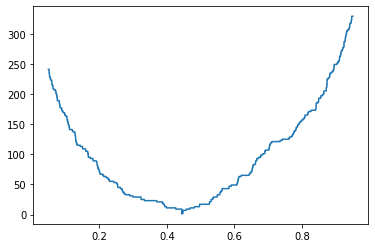

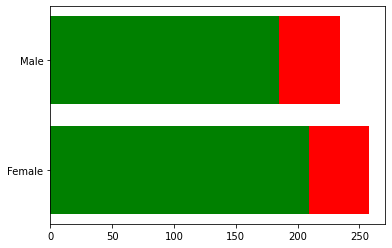


    Test results (Equal Total):
    -------------
    
    Accuracy: 0.801
    
    True positives: 185.000
    False positives: 49.000
    
    True negatives: 209.000
    False negatives: 49.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.791
    True negative rate tn/(tn+fp): 0.810
    
    False negative rate fn/(tp+fn): 0.209
    False positive rate fp/(tn+fp): 0.190
    
    Positive predicted value tp/(tp+fp): 0.791
    False discovery rate fp/(tp+fp): 0.209
    
    Negative predicted value tn/(tn+fn): 0.810
    False omission rate fn/(tn+fn): 0.190
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -24.000
    Demographic parity tp+fp: 234.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.019
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.049
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.476
    
    Binary predictive rate parity diff (tp/(tp+fp))-

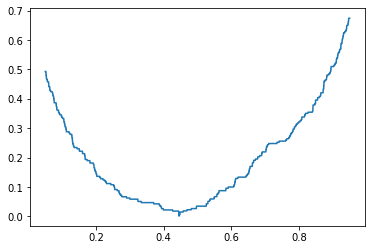

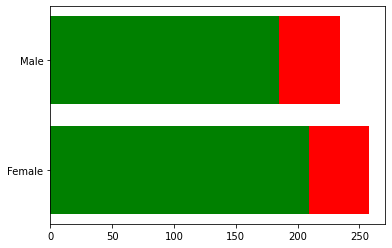


    Test results (Equal Odds):
    -------------
    
    Accuracy: 0.801
    
    True positives: 185.000
    False positives: 49.000
    
    True negatives: 209.000
    False negatives: 49.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.791
    True negative rate tn/(tn+fp): 0.810
    
    False negative rate fn/(tp+fn): 0.209
    False positive rate fp/(tn+fp): 0.190
    
    Positive predicted value tp/(tp+fp): 0.791
    False discovery rate fp/(tp+fp): 0.209
    
    Negative predicted value tn/(tn+fn): 0.810
    False omission rate fn/(tn+fn): 0.190
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -24.000
    Demographic parity tp+fp: 234.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.019
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.049
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.476
    
    Binary predictive rate parity diff (tp/(tp+fp))-(

<Figure size 432x288 with 0 Axes>

In [5]:
test_predict, test_labels, dir_name = ev.testModel(model, ds_test, test_batches, dir_name)
ev.testModelWithThresholdChange(model, ds_val, val_batches, test_predict, test_labels, dir_name)

# FairFace training

In [6]:
class_weight = mit.findClassWeights(fftrain_batches)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = m.build_model(False, (300,300), "Efficient")
    metric_list = m.metrics_list()

model.compile(optimizer=tf.keras.optimizers.Adam(5e-5), 
                           loss="binary_crossentropy", 
                           metrics=metric_list)


utils.train_model(model, epochs, ffds_train, fftrain_batches, ffds_val, ffval_batches, None, False)

print("Make folder...")
dir_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "_EfficientNet_FairFace"
os.mkdir(dir_name)

utils.saveModel(model, dir_name + "/EfficientNet_FairFace.h5")

Weight for class 0: 1.06
Weight for class 1: 0.94
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


/apps/Arch/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


sc
Epoch 1/20
2443/2443 [==============================] - ETA: 0s - loss: 0.4198 - accuracy: 0.8027 - true_positives_63: 34081.0000 - true_negatives_42: 28657.0000 - false_positives_51: 8079.0000 - false_negatives_54: 7341.0000 - true_positive_rate: 0.8228 - true_negative_rate: 0.7801 - false_positive_rate: 0.2199 - false_negative_rate: 0.1772 - positive_predicted_value: 0.8084 - false_discovery_rate: 0.1916 - negative_predicted_value: 0.7961 - false_omission_rate: 0.2039 - binary_demographic_parity_diff: 6162.0000 - demographic_parity: 42160.0000 - binary_equalized_odds_diff: -0.0427 - binary_proportional_parity_diff: 0.0788 - proportional_parity: 0.5394 - binary_predictive_rate_parity_diff: 0.0123 - predictive_rate_parity: 0.8084 - binary_accuracy_parity_diff: 0.6054 - accuracy_parity: 0.8027 - false_negative_rate_parity_diff: 0.0427 - false_positive_rate_parity_diff: -0.0427 - binary_negative_predictive_rate_parity_diff: -0.0123 - negative_predictive_rate_parity: 0.8084 - binary_sp

KeyboardInterrupt: 

Testing Model
-------------
306/306 - 35s - 35s/epoch - 113ms/step
Plot Histogram...


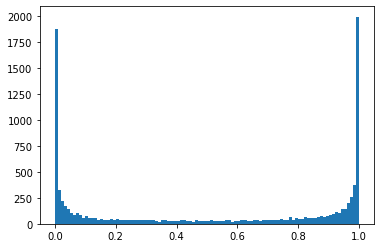

Plot ROC...


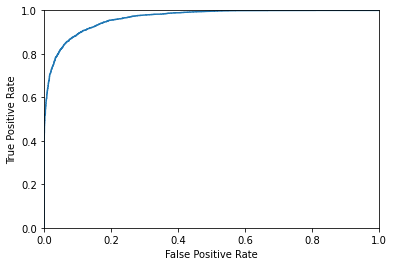

Plot Confusion matrix...


<Figure size 432x288 with 0 Axes>

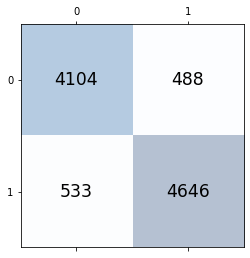

Plot Results...


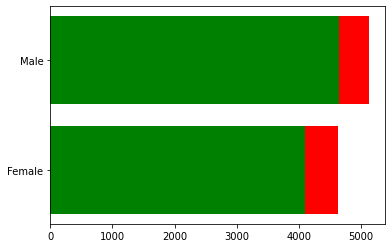


    Test results (Without threshold change):
    -------------
    
    Accuracy: 0.896
    
    True positives: 4646.000
    False positives: 488.000
    
    True negatives: 4104.000
    False negatives: 533.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.897
    True negative rate tn/(tn+fp): 0.894
    
    False negative rate fn/(tp+fn): 0.103
    False positive rate fp/(tn+fp): 0.106
    
    Positive predicted value tp/(tp+fp): 0.905
    False discovery rate fp/(tp+fp): 0.095
    
    Negative predicted value tn/(tn+fn): 0.885
    False omission rate fn/(tn+fn): 0.115
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 497.000
    Demographic parity tp+fp: 5134.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): 0.003
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.051
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.525
    
    Binary predictive rate parity di

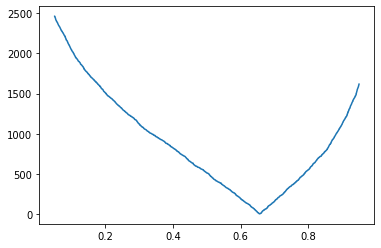

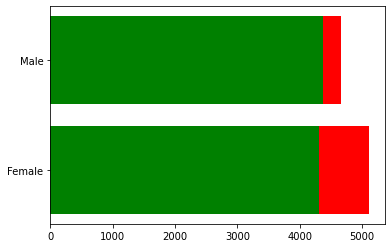


    Test results (Equal True):
    -------------
    
    Accuracy: 0.889
    
    True positives: 4374.000
    False positives: 283.000
    
    True negatives: 4309.000
    False negatives: 805.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.845
    True negative rate tn/(tn+fp): 0.938
    
    False negative rate fn/(tp+fn): 0.155
    False positive rate fp/(tn+fp): 0.062
    
    Positive predicted value tp/(tp+fp): 0.939
    False discovery rate fp/(tp+fp): 0.061
    
    Negative predicted value tn/(tn+fn): 0.843
    False omission rate fn/(tn+fn): 0.157
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -457.000
    Demographic parity tp+fp: 4657.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.094
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.047
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.477
    
    Binary predictive rate parity diff (tp/(tp+

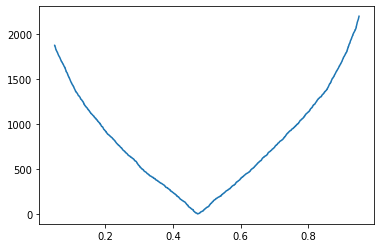

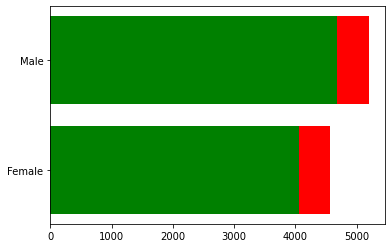


    Test results (Equal False):
    -------------
    
    Accuracy: 0.896
    
    True positives: 4682.000
    False positives: 524.000
    
    True negatives: 4068.000
    False negatives: 497.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.904
    True negative rate tn/(tn+fp): 0.886
    
    False negative rate fn/(tp+fn): 0.096
    False positive rate fp/(tn+fp): 0.114
    
    Positive predicted value tp/(tp+fp): 0.899
    False discovery rate fp/(tp+fp): 0.101
    
    Negative predicted value tn/(tn+fn): 0.891
    False omission rate fn/(tn+fn): 0.109
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 641.000
    Demographic parity tp+fp: 5206.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): 0.018
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.066
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.533
    
    Binary predictive rate parity diff (tp/(tp+fp

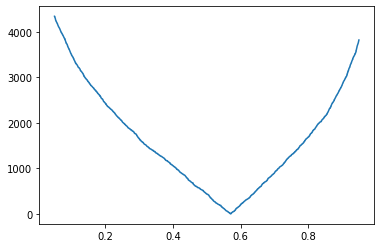

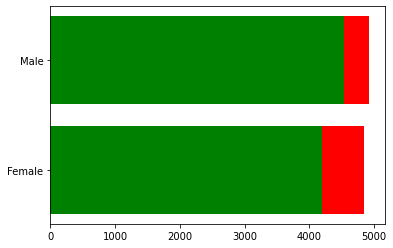


    Test results (Equal Total):
    -------------
    
    Accuracy: 0.894
    
    True positives: 4535.000
    False positives: 389.000
    
    True negatives: 4203.000
    False negatives: 644.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.876
    True negative rate tn/(tn+fp): 0.915
    
    False negative rate fn/(tp+fn): 0.124
    False positive rate fp/(tn+fp): 0.085
    
    Positive predicted value tp/(tp+fp): 0.921
    False discovery rate fp/(tp+fp): 0.079
    
    Negative predicted value tn/(tn+fn): 0.867
    False omission rate fn/(tn+fn): 0.133
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 77.000
    Demographic parity tp+fp: 4924.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.040
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.008
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.504
    
    Binary predictive rate parity diff (tp/(tp+fp

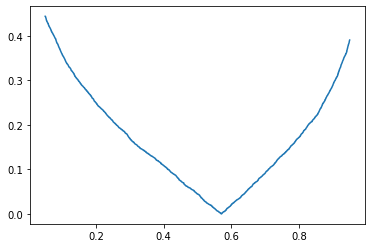

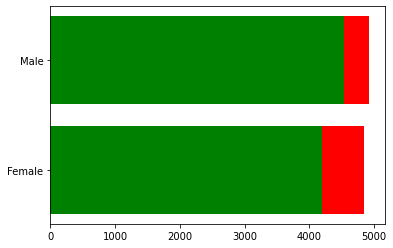


    Test results (Equal Odds):
    -------------
    
    Accuracy: 0.894
    
    True positives: 4535.000
    False positives: 389.000
    
    True negatives: 4203.000
    False negatives: 644.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.876
    True negative rate tn/(tn+fp): 0.915
    
    False negative rate fn/(tp+fn): 0.124
    False positive rate fp/(tn+fp): 0.085
    
    Positive predicted value tp/(tp+fp): 0.921
    False discovery rate fp/(tp+fp): 0.079
    
    Negative predicted value tn/(tn+fn): 0.867
    False omission rate fn/(tn+fn): 0.133
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 77.000
    Demographic parity tp+fp: 4924.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.040
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.008
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.504
    
    Binary predictive rate parity diff (tp/(tp+fp)

<Figure size 432x288 with 0 Axes>

In [7]:
test_predict, test_labels, dir_name = ev.testModel(model, ffds_test, fftest_batches, dir_name)
ev.testModelWithThresholdChange(model, ffds_val, ffval_batches, test_predict, test_labels, dir_name)

In [11]:
model.summary()
print(len(model.layers))

print("Make folder...")
dir_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "_EfficientNet_FairFace"
os.mkdir(dir_name)

utils.saveModel(model, dir_name + "/EfficientNet_FairFace.h5")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 300, 300, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 300, 300, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

/apps/Arch/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Transfer learning

In [14]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = utils.loadModel(dir_name + "/EfficientNet_FairFace.h5", m.metrics_dict())
    metric_list = m.metrics_list()
    
utils.freezeCertainLayers(model, 200)    
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                           loss="binary_crossentropy", 
                           metrics=metric_list)

utils.train_model(model, epochs, ds_train, train_batches, ds_val, val_batches, class_weight)

print("Make folder...")
dir_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "_EfficientNet_transfer"
os.mkdir(dir_name)

print("Name directory: " + dir_name)
utils.saveModel(model, dir_name + "/EfficientNet_transfer.h5")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
sc
Epoch 1/20
123/123 [==============================] - 80s 309ms/step - loss: 0.6127 - accuracy: 0.6902 - true_positives_266: 1376.0000 - true_negatives_175: 1327.0000 - false_positives_214: 728.0000 - false_negatives_227: 485.0000 - true_positive_rate: 0.7394 - true_negative_rate: 0.6457 - false_positive_rate: 0.3543 - false_negative_rate: 0.2606 - positive_predicted_value: 0.6540 - false_discovery_rate: 0.3460 - negative_predicted_value: 0.7323 - false_omission_rate: 0.2677 - binary_demographic_parity_diff: 292.0000 - demographic_parity: 2104.0000 - binary_equalized_odds_diff: -0.0936 - binary_proportional_parity_diff: 0.0746 - proportional_parity: 0.5373 - binary_predictive_rate_parity_diff: -0.0783 - predictive_rate_parity: 0.6540 - binary_accuracy_parity_diff: 0.3805 - accuracy_parity: 0.6902 - false_negative_rate_parity_diff: 0.0936 - false_positive_rate_parity_diff: -0.0936 - 

sc
Epoch 5/20
123/123 [==============================] - 27s 222ms/step - loss: 0.2761 - accuracy: 0.8784 - true_positives_266: 1597.0000 - true_negatives_175: 1843.0000 - false_positives_214: 228.0000 - false_negatives_227: 248.0000 - true_positive_rate: 0.8656 - true_negative_rate: 0.8899 - false_positive_rate: 0.1101 - false_negative_rate: 0.1344 - positive_predicted_value: 0.8751 - false_discovery_rate: 0.1249 - negative_predicted_value: 0.8814 - false_omission_rate: 0.1186 - binary_demographic_parity_diff: -266.0000 - demographic_parity: 1825.0000 - binary_equalized_odds_diff: 0.0243 - binary_proportional_parity_diff: -0.0679 - proportional_parity: 0.4660 - binary_predictive_rate_parity_diff: -0.0063 - predictive_rate_parity: 0.8751 - binary_accuracy_parity_diff: 0.7569 - accuracy_parity: 0.8784 - false_negative_rate_parity_diff: -0.0243 - false_positive_rate_parity_diff: 0.0243 - binary_negative_predictive_rate_parity_diff: 0.0063 - negative_predictive_rate_parity: 0.8751 - binar

Testing Model
-------------
16/16 - 6s - 6s/epoch - 390ms/step
Plot Histogram...


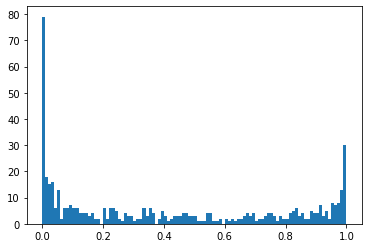

Plot ROC...


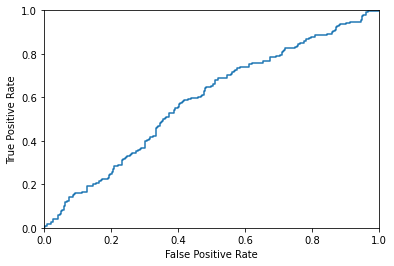

Plot Confusion matrix...


<Figure size 432x288 with 0 Axes>

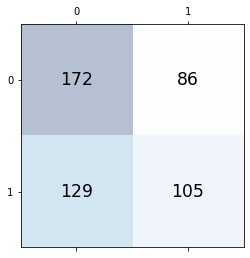

Plot Results...


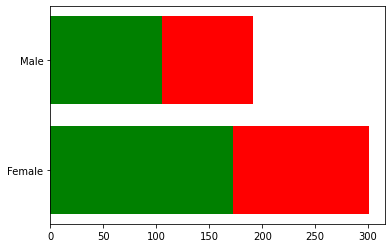


    Test results (Without threshold change):
    -------------
    
    Accuracy: 0.563
    
    True positives: 105.000
    False positives: 86.000
    
    True negatives: 172.000
    False negatives: 129.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.449
    True negative rate tn/(tn+fp): 0.667
    
    False negative rate fn/(tp+fn): 0.551
    False positive rate fp/(tn+fp): 0.333
    
    Positive predicted value tp/(tp+fp): 0.550
    False discovery rate fp/(tp+fp): 0.450
    
    Negative predicted value tn/(tn+fn): 0.571
    False omission rate fn/(tn+fn): 0.429
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -110.000
    Demographic parity tp+fp: 191.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.218
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.224
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.388
    
    Binary predictive rate parity dif

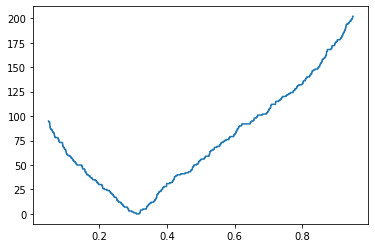

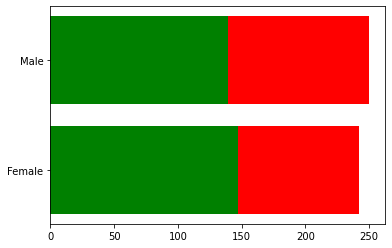


    Test results (Equal True):
    -------------
    
    Accuracy: 0.581
    
    True positives: 139.000
    False positives: 111.000
    
    True negatives: 147.000
    False negatives: 95.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.594
    True negative rate tn/(tn+fp): 0.570
    
    False negative rate fn/(tp+fn): 0.406
    False positive rate fp/(tn+fp): 0.430
    
    Positive predicted value tp/(tp+fp): 0.556
    False discovery rate fp/(tp+fp): 0.444
    
    Negative predicted value tn/(tn+fn): 0.607
    False omission rate fn/(tn+fn): 0.393
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 8.000
    Demographic parity tp+fp: 250.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): 0.024
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.016
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.508
    
    Binary predictive rate parity diff (tp/(tp+fp))-(tn/

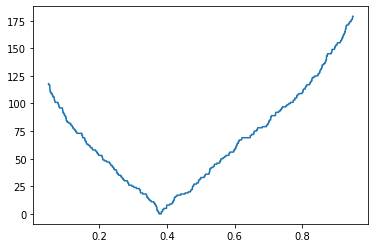

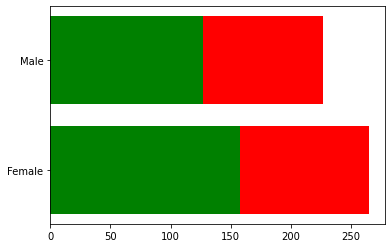


    Test results (Equal False):
    -------------
    
    Accuracy: 0.579
    
    True positives: 127.000
    False positives: 100.000
    
    True negatives: 158.000
    False negatives: 107.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.543
    True negative rate tn/(tn+fp): 0.612
    
    False negative rate fn/(tp+fn): 0.457
    False positive rate fp/(tn+fp): 0.388
    
    Positive predicted value tp/(tp+fp): 0.559
    False discovery rate fp/(tp+fp): 0.441
    
    Negative predicted value tn/(tn+fn): 0.596
    False omission rate fn/(tn+fn): 0.404
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -38.000
    Demographic parity tp+fp: 227.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.070
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.077
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.461
    
    Binary predictive rate parity diff (tp/(tp+fp)

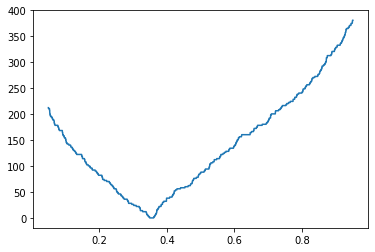

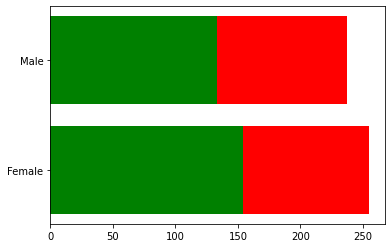


    Test results (Equal Total):
    -------------
    
    Accuracy: 0.583
    
    True positives: 133.000
    False positives: 104.000
    
    True negatives: 154.000
    False negatives: 101.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.568
    True negative rate tn/(tn+fp): 0.597
    
    False negative rate fn/(tp+fn): 0.432
    False positive rate fp/(tn+fp): 0.403
    
    Positive predicted value tp/(tp+fp): 0.561
    False discovery rate fp/(tp+fp): 0.439
    
    Negative predicted value tn/(tn+fn): 0.604
    False omission rate fn/(tn+fn): 0.396
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -18.000
    Demographic parity tp+fp: 237.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.029
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.037
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.482
    
    Binary predictive rate parity diff (tp/(tp+fp)

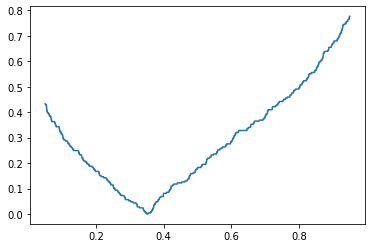

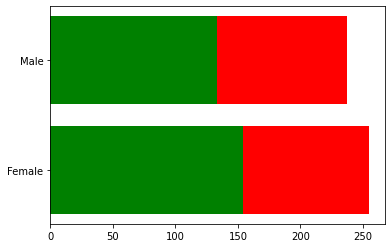


    Test results (Equal Odds):
    -------------
    
    Accuracy: 0.583
    
    True positives: 133.000
    False positives: 104.000
    
    True negatives: 154.000
    False negatives: 101.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.568
    True negative rate tn/(tn+fp): 0.597
    
    False negative rate fn/(tp+fn): 0.432
    False positive rate fp/(tn+fp): 0.403
    
    Positive predicted value tp/(tp+fp): 0.561
    False discovery rate fp/(tp+fp): 0.439
    
    Negative predicted value tn/(tn+fn): 0.604
    False omission rate fn/(tn+fn): 0.396
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -18.000
    Demographic parity tp+fp: 237.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.029
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.037
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.482
    
    Binary predictive rate parity diff (tp/(tp+fp))

<Figure size 432x288 with 0 Axes>

In [16]:
test_predict, test_labels, dir_name = ev.testModel(model, ds_test, test_batches, dir_name)
ev.testModelWithThresholdChange(model, ds_val, val_batches, test_predict, test_labels, dir_name)